# Chicken Weights by Feed Type

## Dataset

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

*Source: Anonymous (1948) Biometrika, 35, 214.*



## Required Packages

In [1]:
library(tidyverse)
library(rjags)

source("funcs.R")

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



## Data

In [2]:
data = datasets::chickwts %>%
  mutate(
    feed_name = feed,
    feed = as.numeric(feed)
    )

In [5]:
str(data)

'data.frame':	71 obs. of  3 variables:
 $ weight   : num  179 160 136 227 217 168 108 124 143 140 ...
 $ feed     : num  2 2 2 2 2 2 2 2 2 2 ...
 $ feed_name: Factor w/ 6 levels "casein","horsebean",..: 2 2 2 2 2 2 2 2 2 2 ...


In [3]:
head(data)

,weight,feed,feed_name
,<dbl>,<dbl>,<fct>
1,179,2,horsebean
2,160,2,horsebean
3,136,2,horsebean
4,227,2,horsebean
5,217,2,horsebean
6,168,2,horsebean


In [4]:
table(data$feed_name)


   casein horsebean   linseed  meatmeal   soybean sunflower 
       12        10        12        11        14        12 

### Distribution of Weights by Feed Type

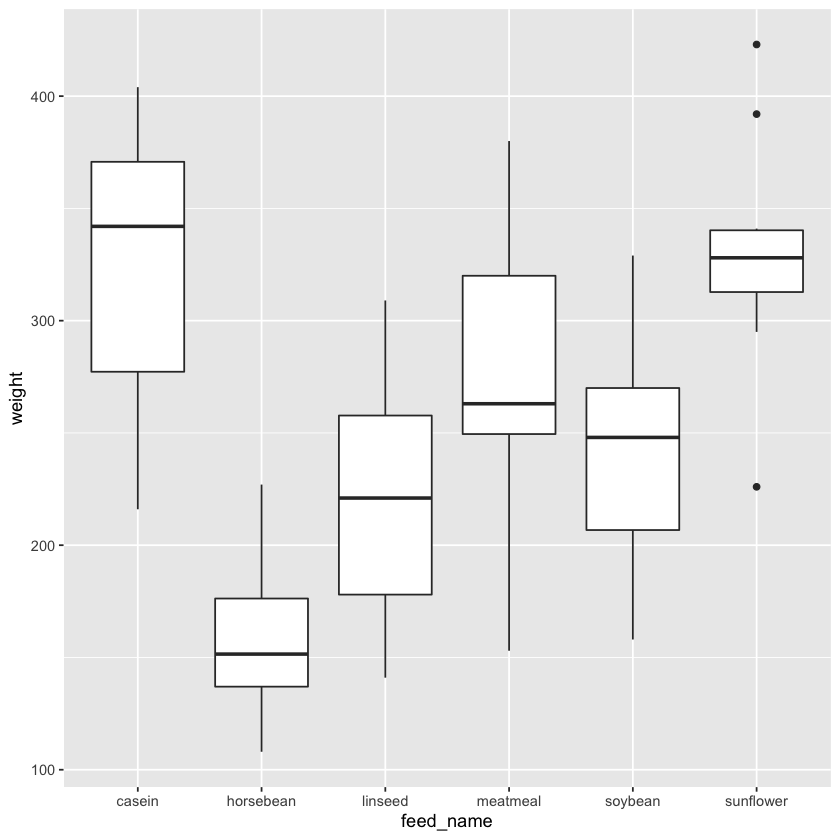

In [6]:
ggplot(data, aes(x=feed_name, y=weight, group=feed_name)) +
  geom_boxplot()

In [50]:
data %>%
    filter(feed_name=="sunflower")

weight,feed,feed_name
<dbl>,<dbl>,<fct>
423,6,sunflower
340,6,sunflower
392,6,sunflower
339,6,sunflower
341,6,sunflower
226,6,sunflower
320,6,sunflower
295,6,sunflower
334,6,sunflower


## Models

### Base Linear Model

In [8]:
mod.base = lm(weight ~ feed_name + 0, data=data)
summary(mod.base)


Call:
lm(formula = weight ~ feed_name + 0, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-123.909  -34.413    1.571   38.170  103.091 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
feed_namecasein      323.58      15.83  20.436  < 2e-16 ***
feed_namehorsebean   160.20      17.35   9.236 1.91e-13 ***
feed_namelinseed     218.75      15.83  13.815  < 2e-16 ***
feed_namemeatmeal    276.91      16.54  16.744  < 2e-16 ***
feed_namesoybean     246.43      14.66  16.810  < 2e-16 ***
feed_namesunflower   328.92      15.83  20.773  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.85 on 65 degrees of freedom
Multiple R-squared:  0.9629,	Adjusted R-squared:  0.9595 
F-statistic: 281.4 on 6 and 65 DF,  p-value: < 2.2e-16


### Pooled Model

$$ Weight_{ij} \sim Normal(\mu, \sigma) $$

In [7]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(mu, prec)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec ~ dexp(1)
  sigma = sqrt(1/prec)
} "

set.seed(43)
data_jags = as.list(data)
params = c("mu", "sigma")

mod.pooled = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed" in data”
Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 2
   Total graph size: 79

Initializing model



#### Results

In [17]:
summary(mod.pooled$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean    SD Naive SE Time-series SE
mu    261.19 9.262  0.07562        0.07562
sigma  77.82 6.578  0.05371        0.05602

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
mu    242.85 255.04 261.20 267.24 279.53
sigma  66.19  73.21  77.36  81.94  92.04


In [9]:
round(mod.pooled$coefs, 4)

mu    sigma 
261.1871  77.8159

In [8]:
(dic.pooled = dic.samples(mod.pooled$obj, n.iter=1e3))

Mean deviance:  821.3 
penalty 2.037 
Penalized deviance: 823.3 

#### Convergence

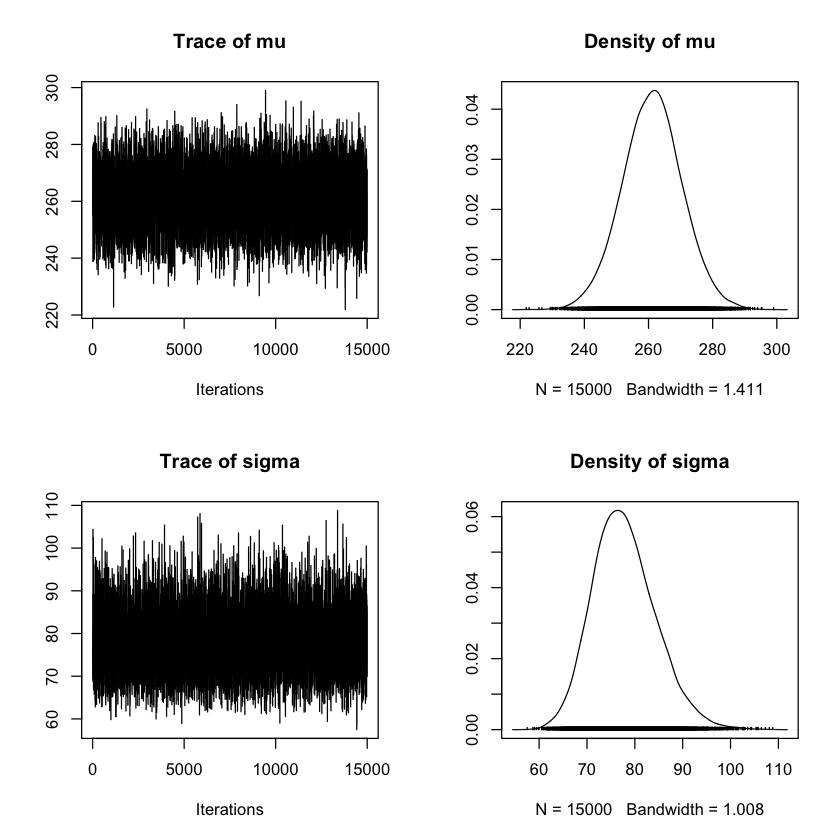

In [10]:
plot(mod.pooled$csim)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



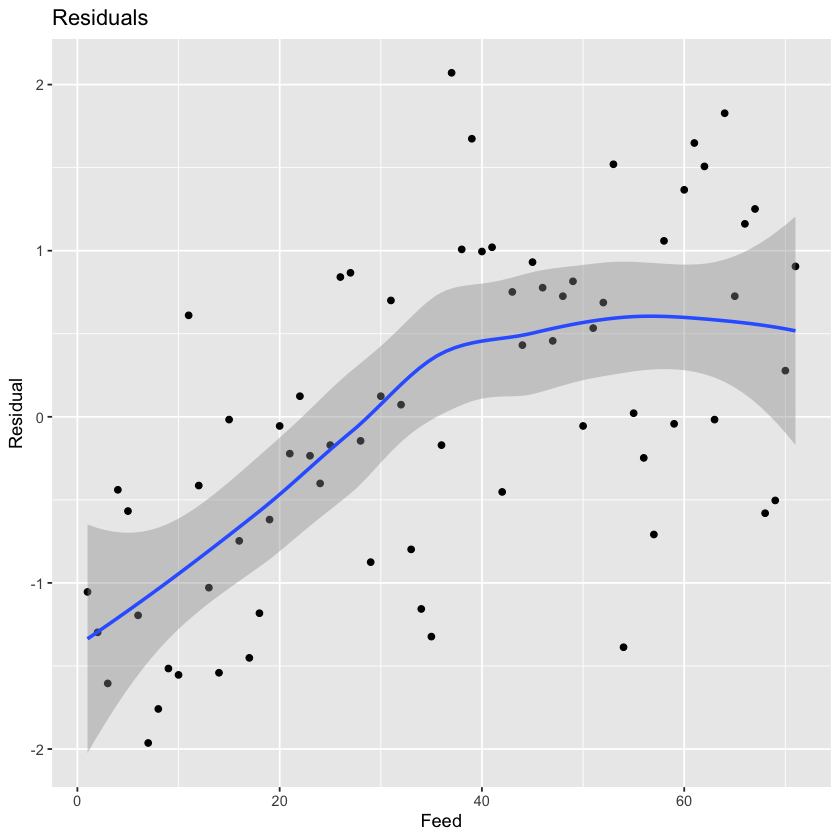

In [28]:
res = data$weight - mod.pooled$coefs[1]
gg_resid(res, normalize=TRUE)

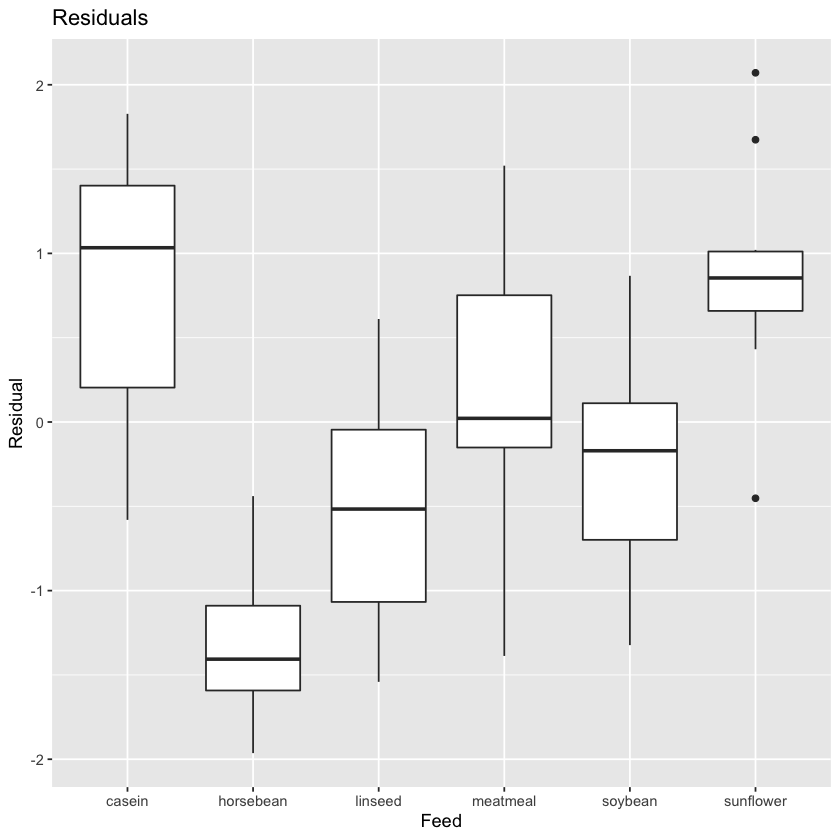

In [24]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Hierarchical Model

### Homogenous Variance

$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu, \tau) $$

In [70]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  prec.sigma ~ dexp(1)
  tau = sqrt(1/prec.tau)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 9
   Total graph size: 159

Initializing model



#### Results

In [71]:
summary(mod.hier$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
mu       258.98 25.513  0.20832        0.22358
sigma     54.88  4.841  0.03953        0.04305
theta[1] 317.72 15.578  0.12719        0.13543
theta[2] 170.78 17.737  0.14482        0.17119
theta[3] 222.50 15.325  0.12512        0.12863
theta[4] 274.95 16.045  0.13101        0.13595
theta[5] 247.50 14.320  0.11692        0.12004
theta[6] 322.64 15.677  0.12801        0.13730

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       206.80 243.89 259.33 274.11 309.32
sigma     46.39  51.47  54.53  57.94  65.18
theta[1] 286.84 307.41 317.73 328.02 348.60
theta[2] 136.37 158.86 170.62 182.38 206.24
theta[3] 192.66 212.16 222.41 232.81 253.09
theta[4] 243.50 264.15 274.87 285.99 306.39
theta[5] 219.23 238.08 247.65 257.18 2

In [72]:
round(mod.hier$coefs, 4)

mu    sigma theta[1] theta[2] theta[3] theta[4] theta[5] theta[6] 
258.9765  54.8793 317.7172 170.7764 222.5047 274.9454 247.5012 322.6350

In [73]:
(dic.hier = dic.samples(mod.hier$obj, n.iter=1e3))

Mean deviance:  771.6 
penalty 7.013 
Penalized deviance: 778.6 

### Heterogenous Variance


$$ Weight_{ij} \sim Normal(\theta_j, \sigma_j) $$

$$ \theta_j \sim Normal(\mu, \tau) $$

$$ \frac{1}{\sigma^2_j} \sim Exp(1) $$

In [74]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma[feed[i]])
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
    prec.sigma[j] ~ dexp(1)
    sigma[j] = sqrt(1/prec.sigma[j])
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  tau = sqrt(1/prec.tau)
  
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier.var.het = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 14
   Total graph size: 174

Initializing model



#### Results

In [75]:
summary(mod.hier.var.het$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
mu       257.73 26.289  0.21465        0.23039
sigma[1]  63.19 13.623  0.11123        0.11993
sigma[2]  38.16  9.504  0.07760        0.09021
sigma[3]  50.93 10.973  0.08959        0.09786
sigma[4]  63.08 14.081  0.11497        0.12478
sigma[5]  53.06 10.448  0.08531        0.08989
sigma[6]  47.97 10.533  0.08600        0.09602
theta[1] 316.19 18.094  0.14774        0.16170
theta[2] 165.68 12.898  0.10531        0.12366
theta[3] 221.73 14.735  0.12031        0.12485
theta[4] 274.57 18.424  0.15043        0.15471
theta[5] 247.17 13.933  0.11376        0.11459
theta[6] 324.02 14.358  0.11723        0.12961

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       205.33 241.60 257.77 273.61 310.49
sigma[1]  43.24  53.76 

In [76]:
round(mod.hier.var.het$coefs, 4)

mu sigma[1] sigma[2] sigma[3] sigma[4] sigma[5] sigma[6] theta[1] 
257.7325  63.1860  38.1639  50.9316  63.0769  53.0588  47.9664 316.1943 
theta[2] theta[3] theta[4] theta[5] theta[6] 
165.6781 221.7317 274.5675 247.1690 324.0188

In [77]:
(dic.hier = dic.samples(mod.hier.var.het$obj, n.iter=1e3))

Mean deviance:  772.3 
penalty 12.93 
Penalized deviance: 785.2 

#### Convergence

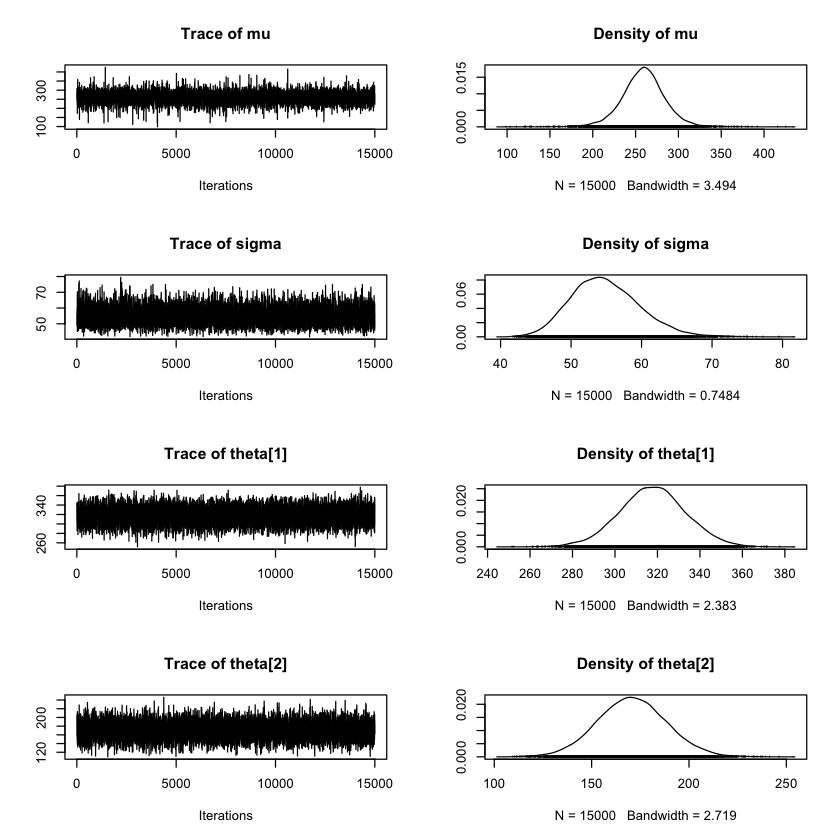

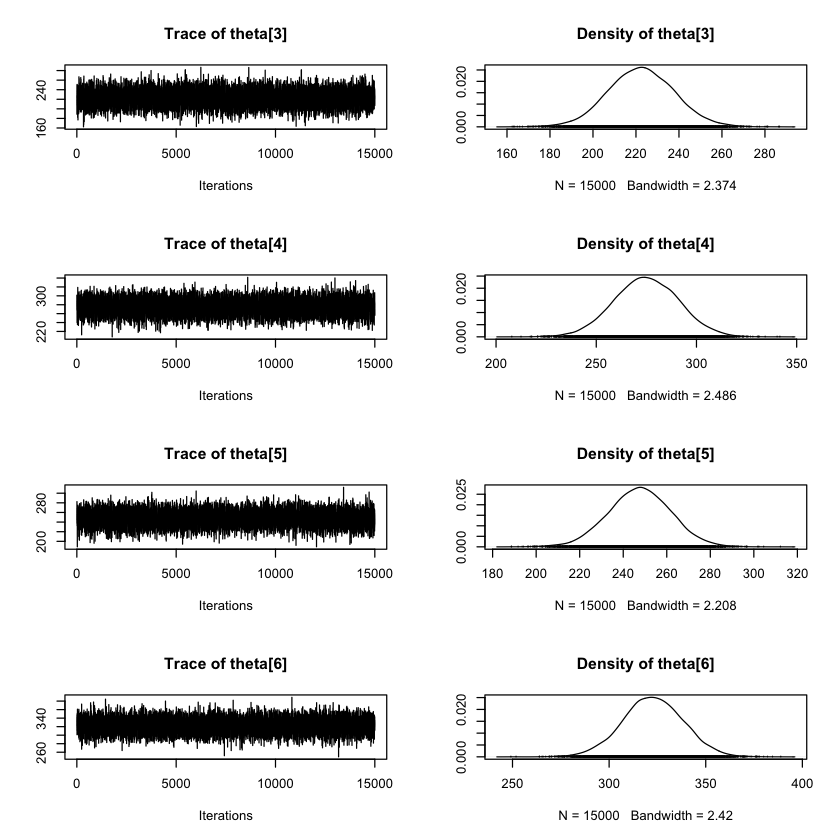

In [78]:
plot(mod.hier$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



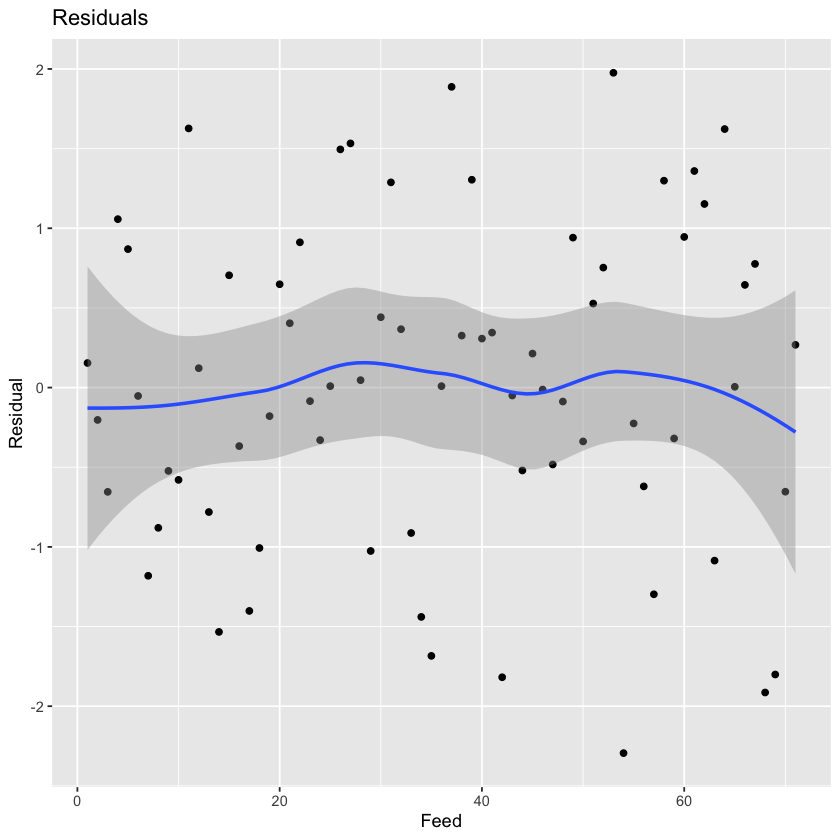

In [79]:
res = data$weight - mod.hier$coefs[3:8][data$feed]
gg_resid(res, normalize=TRUE)

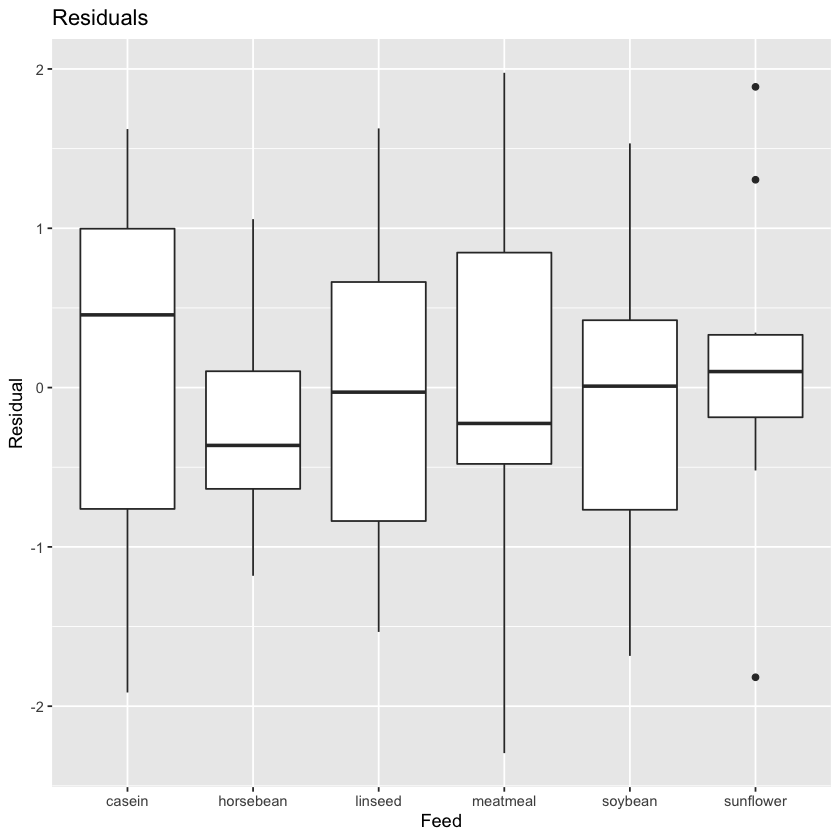

In [80]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Heterogenous Model

$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu_j, \tau_j) $$

In [42]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu[j], prec.tau[j])
    mu[j] ~ dnorm(0, 1.0/1.0e6)
    prec.tau[j] ~ dexp(1)
    tau[j] = sqrt(1/prec.tau[j])
  }
  
  prec.sigma ~ dexp(1)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "tau")

mod.het = run_sim(
    model.str = mod_string,
    data = data_jags,
    params = params,
    burn_in=5e3,
    n_iter=5e4
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 19
   Total graph size: 179

Initializing model



#### Results

In [43]:
summary(mod.het$sim)


Iterations = 5001:55000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean     SD Naive SE Time-series SE
tau[1]     1.803  3.946 0.010189        0.02010
tau[2]     1.746  2.497 0.006447        0.01204
tau[3]     1.786  3.250 0.008390        0.01563
tau[4]     1.757  2.984 0.007705        0.01463
tau[5]     1.756  2.836 0.007321        0.01314
tau[6]     1.748  2.361 0.006095        0.01111
theta[1] 323.597 15.817 0.040840        0.44462
theta[2] 160.812 17.093 0.044133        0.51489
theta[3] 218.412 16.097 0.041563        0.44683
theta[4] 276.123 16.456 0.042490        0.46721
theta[5] 246.683 14.667 0.037869        0.38123
theta[6] 328.536 15.621 0.040333        0.43178

2. Quantiles for each variable:

             2.5%      25%     50%     75%   97.5%
tau[1]     0.5216   0.8502   1.202   1.862   6.377
tau[2]     0.5195   0.8457   1.196   1.85

In [44]:
round(mod.het$coefs, 4)

tau[1]   tau[2]   tau[3]   tau[4]   tau[5]   tau[6] theta[1] theta[2] 
  1.8028   1.7456   1.7857   1.7574   1.7556   1.7479 323.5969 160.8121 
theta[3] theta[4] theta[5] theta[6] 
218.4116 276.1232 246.6827 328.5361

In [45]:
(dic.het = dic.samples(mod.het$obj, n.iter=1e3))

Mean deviance:  771.2 
penalty 7.327 
Penalized deviance: 778.5 

#### Convergence

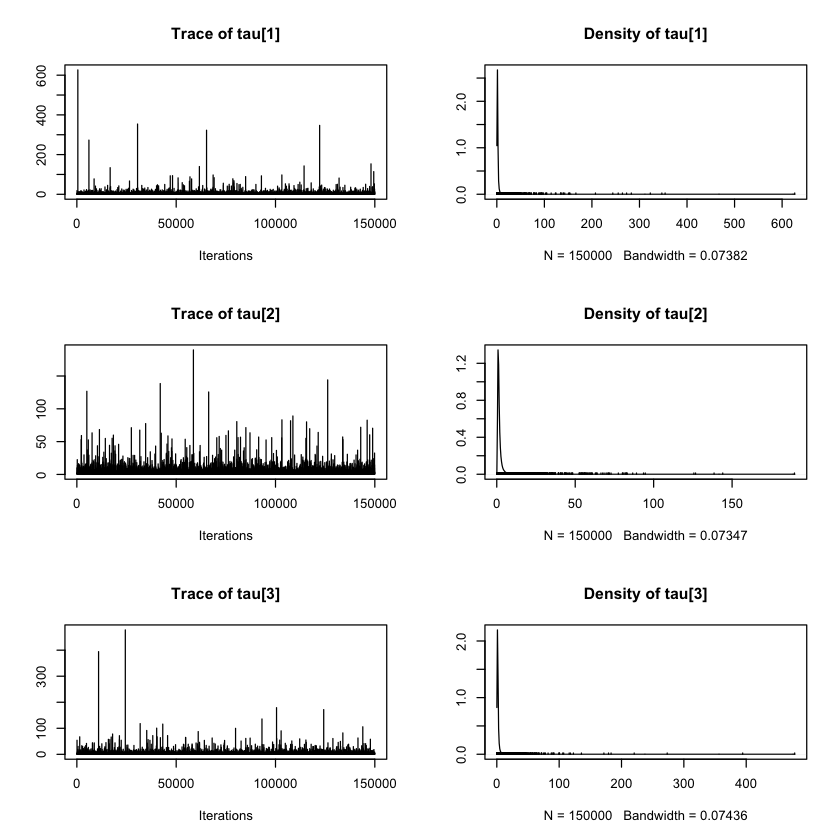

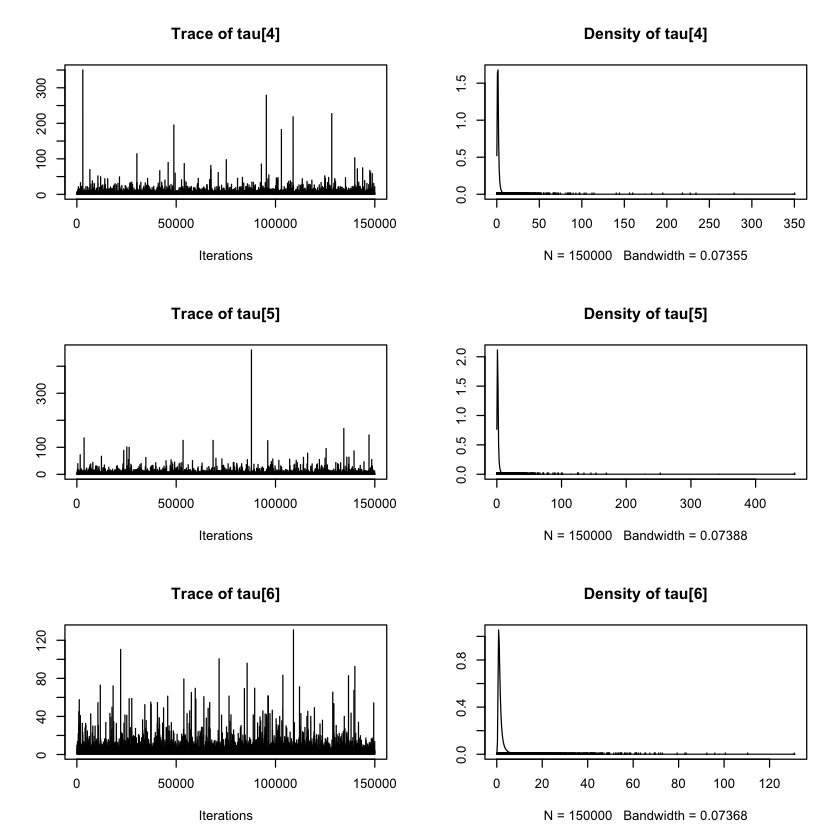

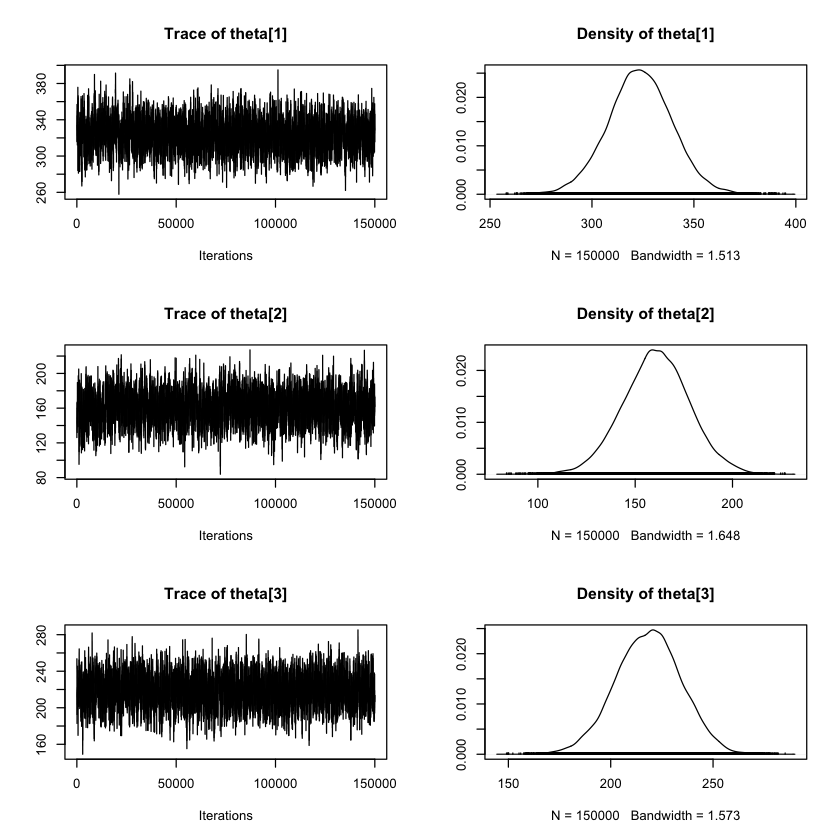

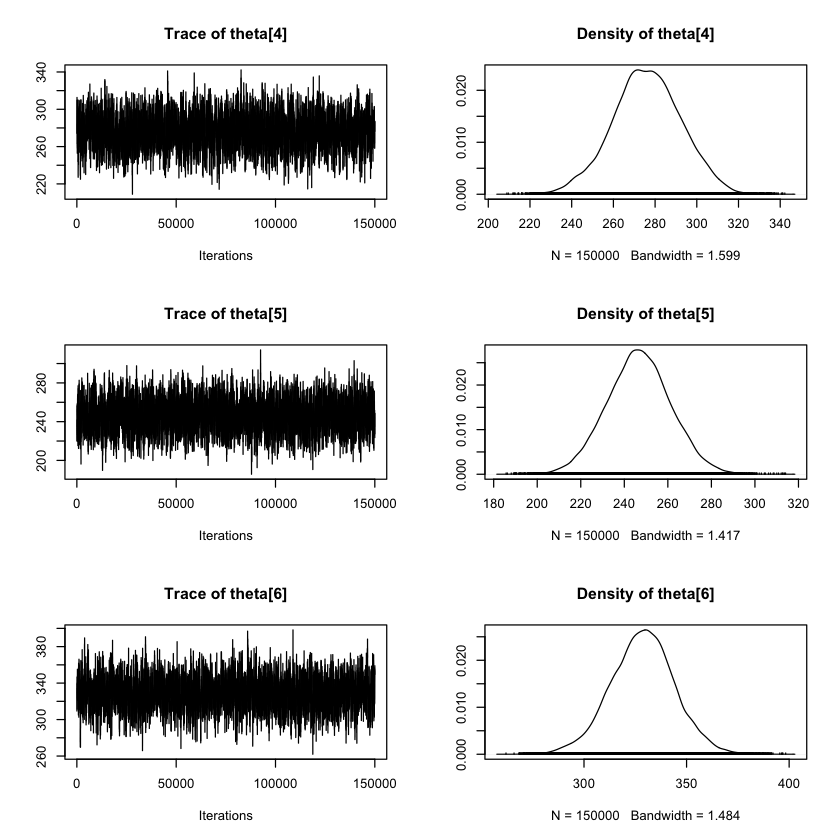

In [46]:
plot(mod.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



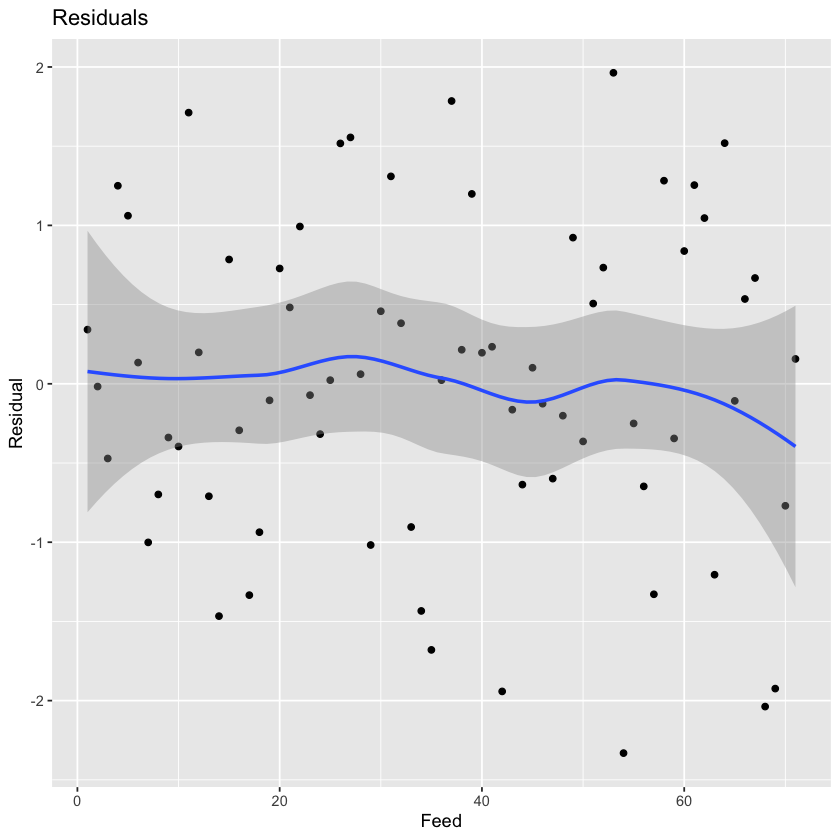

In [47]:
res = data$weight - mod.het$coefs[7:12][data$feed]
gg_resid(res, normalize=TRUE)

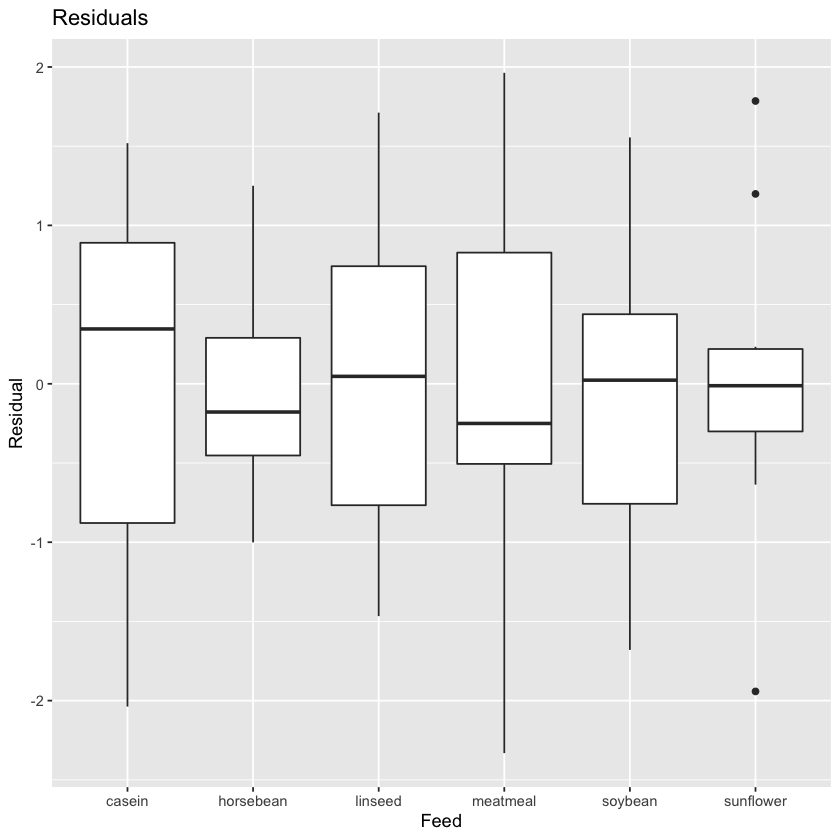

In [48]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Posterior Analysis

[1] 90.83889

[1] 543.9325

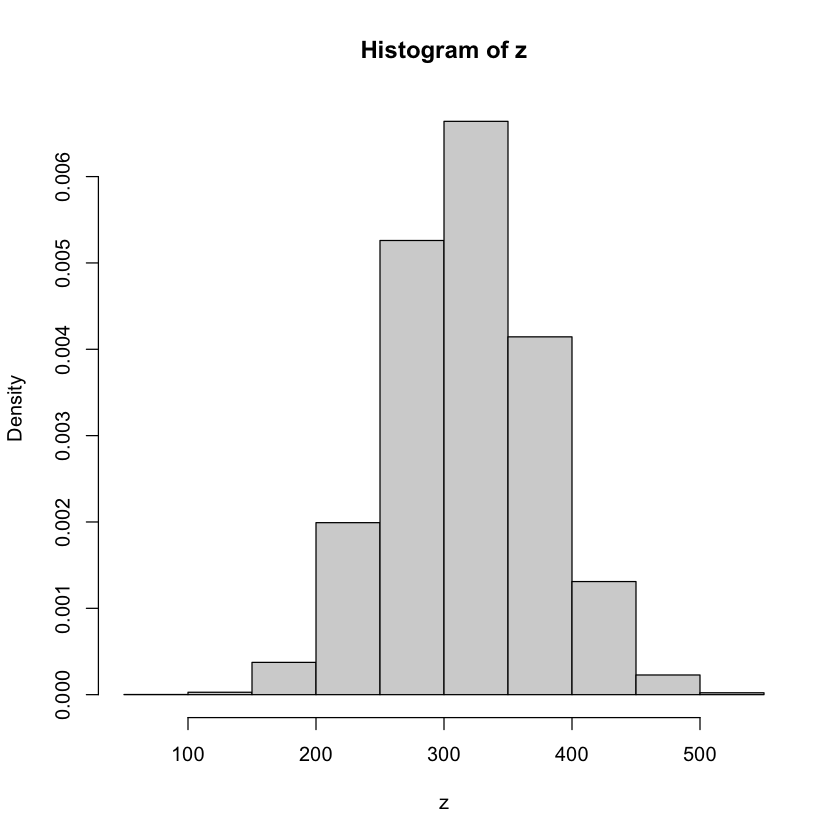

In [102]:
N = 1e4

theta1.post = sample(mod.hier$csim[, 3], N, replace = TRUE)
sigma.post = sample(mod.hier$csim[, 2], N, replace = TRUE)
z = rnorm(N, mean=theta1.post, sd=sigma.post)
hist(z, freq = FALSE)
min(z)
max(z)

In [103]:
mean(mod.hier$csim[, "theta[6]"] > mod.hier$csim[, "theta[1]"])

[1] 0.5899333

In [104]:
set.seed(43)
for (i in 4:8) {
    p = mean(sample(mod.hier$csim[, 3], N, replace = TRUE) > sample(mod.hier$csim[, i], N, replace = TRUE))
    cat("Prob feed # 1 > #", i-2, ": ", p, "\n")
}

Prob feed # 1 > # 2 :  1 
Prob feed # 1 > # 3 :  0.9999 
Prob feed # 1 > # 4 :  0.9723 
Prob feed # 1 > # 5 :  0.9993 
Prob feed # 1 > # 6 :  0.4135 
